In [64]:
import random
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from scipy.ndimage import rotate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn
import math
from sklearn.model_selection import train_test_split
print(f"Tensorflow version: \t{tf.__version__}")
print(f"Keras version: \t\t\t{keras.__version__}")

seed = 19
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version: 	2.20.0
Keras version: 			3.11.3


In [65]:
# Load data

images = np.load("data/images.npy")
labels = np.load("data/labels.npy")

In [66]:
def augment_images(images, labels):
    aug_imgs = [images]
    aug_labels = [labels]
    temp = []

    for img in images:
        aug_img = img.copy()
        aug_img = rotate(aug_img, angle=random.uniform(1, 360), reshape=False, mode="nearest", order=1)
        temp.append(aug_img)

    aug_imgs.append(np.array(temp))
    aug_labels.append(labels.copy())

    return np.vstack(aug_imgs), np.vstack(aug_labels)

def show_augmented_comparison(images, labels, n):
    half = len(images)//2
    indices = np.arange(half)
    np.random.shuffle(indices)

    images_normal = images[:half][indices]
    images_aug = images[half:][indices]
    labels_normal = labels[:half][indices]
    labels_aug = labels[half:][indices]

    images_shuffled = np.vstack([images_normal, images_aug])
    labels_shuffled = np.vstack([labels_normal, labels_aug])

    for i in range(n):
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images_shuffled[i], cmap='gray')
        plt.xlabel(f"Original: {labels_shuffled[i]}")

        # Augmented image (still corresponds to same original)
        plt.subplot(1, 2, 2)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images_shuffled[i + half], cmap='gray')
        plt.xlabel(f"Augmented: {labels_shuffled[i + half]}")

        plt.tight_layout()
        plt.show()

In [67]:
# Process to segment into train, test, and validation sets
images, labels = augment_images(images, labels)
print(images.shape, len(labels))
images = images / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(images,labels,
                                         random_state=19,
                                         test_size=0.2,
                                         shuffle=True,
                                         stratify=labels)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp,
                                       test_size=0.5,
                                       shuffle=True,
                                       stratify=y_temp)



(36000, 75, 75) 36000


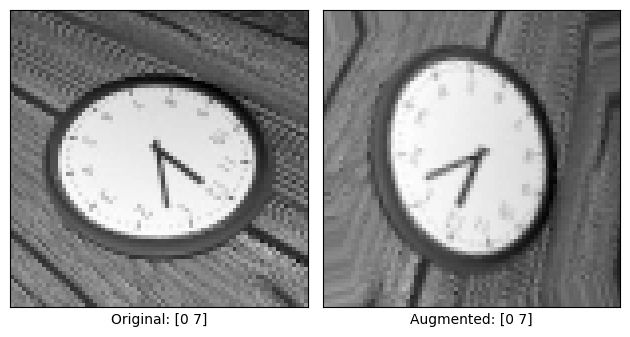

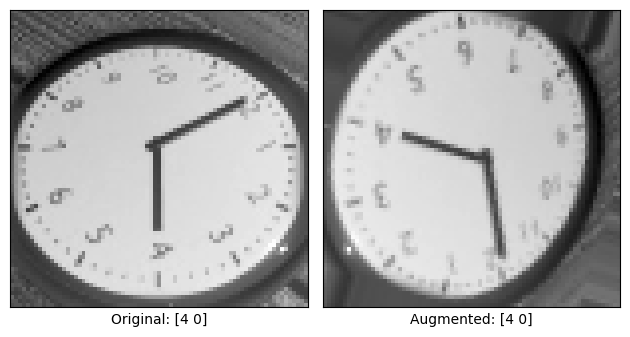

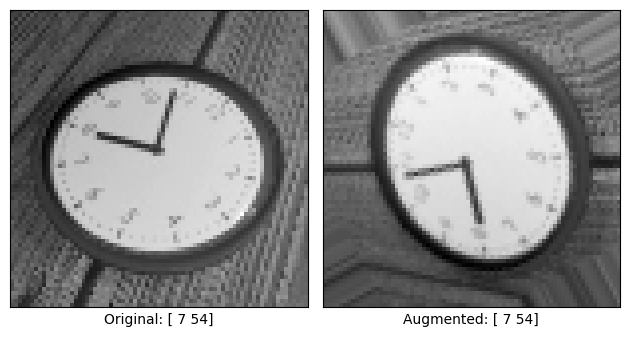

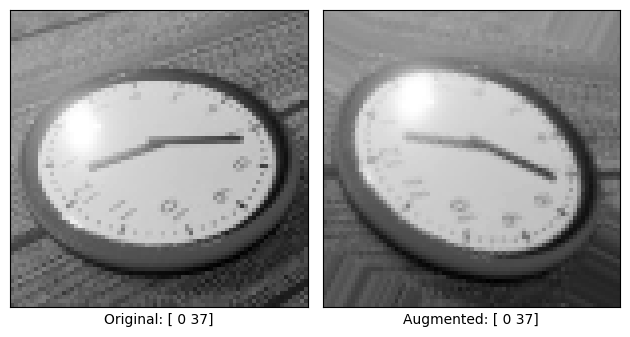

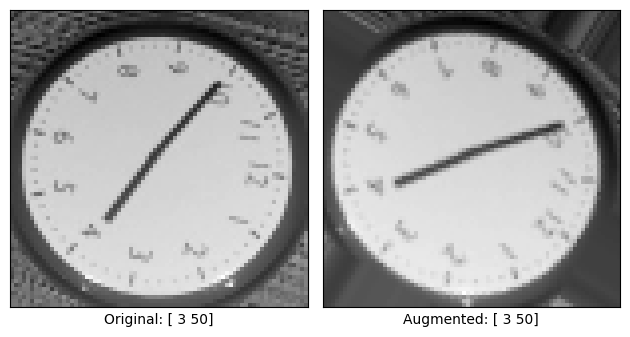

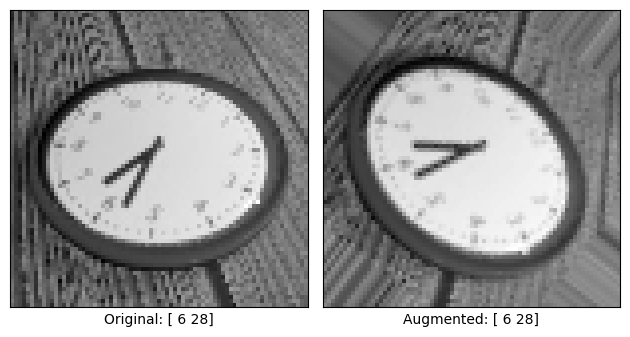

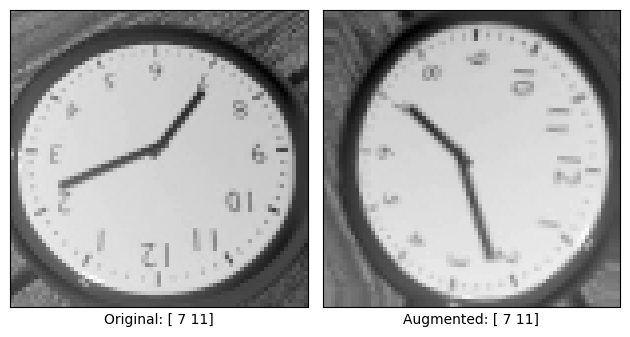

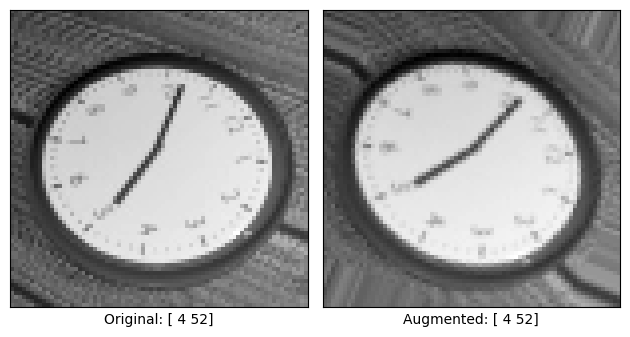

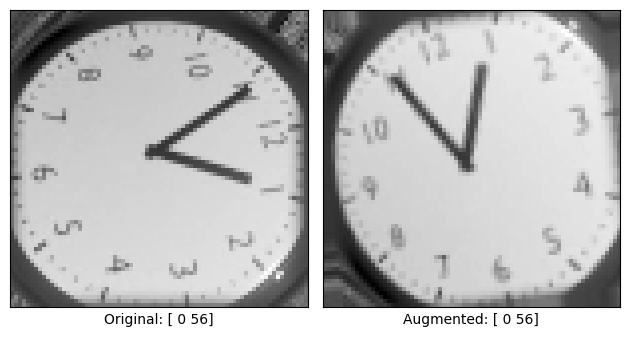

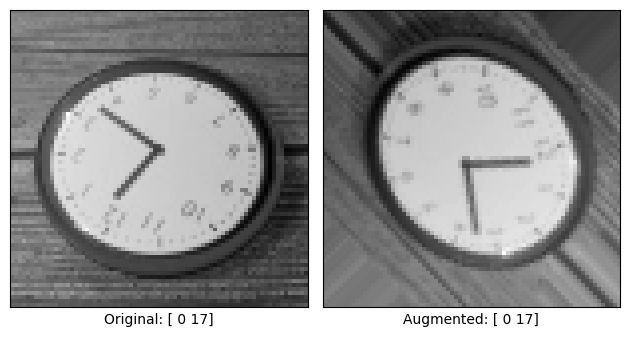

In [68]:
show_augmented_comparison(images, labels, 10)

In [69]:
print(X_train.shape, len(y_train))
print(X_val.shape, len(y_val))
print(X_test.shape, len(y_test))

(28800, 75, 75) 28800
(3600, 75, 75) 3600
(3600, 75, 75) 3600


In [70]:
# We're doing this so the distance between y_pred and y of the hour and minutes arms are being measured fairly

def normalize_time(y):
    vals = []
    for time in y:
        vals.append([(time[0]+1)/12, (time[1]+1)/60])
    return np.array(vals)

y_val_norm = normalize_time(y_val)
y_train_norm = normalize_time(y_train)
y_test_norm = normalize_time(y_test)

In [71]:
# Change the interval to any lower number (in minutes) to get more or less classes to compare the difference

def class_convert_classification(y, interval=30, clock=12*60):
    vals = []
    # You can use the class labels to correspond to different classes after cnn output
    class_labels = np.array([[i, j] for i in range(int(clock/60)) for j in [0, interval]])

    for hr, min in y:
        # Assigns a value in range 0, 23 for each hour minute combination, resulting in 24*60/interval classes. 0 for 0-30 min, 1 for 30 min-1 hr for interval=30, etc.
        classification_val = math.floor(min/interval + hr*60/interval)
        vals.append(classification_val)
        # Shows all values lock to the first floor
        # print(f"{hr:02d}:{min:02d} = {class_labels[classification_val]}")
        # print(f"Actual value: {hr} hours, {min} minutes")
        # print(f"Corresponding label for classification: {classification_val}")

    return np.array(vals), class_labels

y_test_class, class_labels = class_convert_classification(y_test)
y_train_class, _ = class_convert_classification(y_train)
y_val_class, _ = class_convert_classification(y_val)

In [72]:
def class_convert_regression(y):
    vals = []
    for a in y:
        vals.append(int(a[0]) + float(a[1] / 60))
    return np.array(vals)

y_test_reg = class_convert_regression(y_test)
y_train_reg = class_convert_regression(y_train)
y_val_reg = class_convert_regression(y_val)

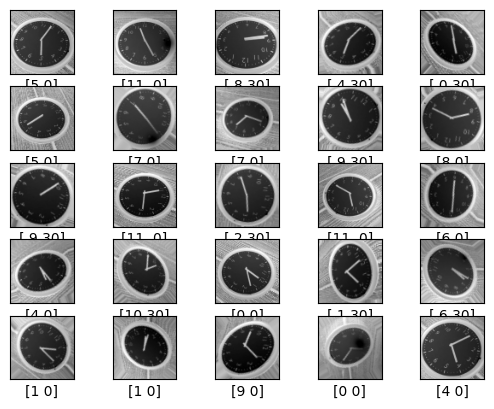

In [73]:
# Plotting with some code from tensorflow.org

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(1 - X_val[i], cmap="gray")
    plt.xlabel(class_labels[y_val_class[i]])
    # plt.xlabel(y_val[i])
    # print(f"{class_labels[y_val_class[i]]} = {y_val[i]}" )
plt.show()

In [74]:
# Creating the CNN CLASSIFICATION class_model
width, height = X_train.shape[1], X_train.shape[2]
n_classes = len(class_labels)

# Classification class_model
class_model = models.Sequential([
    layers.Input(shape=(height, width, 1)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 4 (optional - add if images are large, e.g., 200x200+)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.0005)
class_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

class_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 75, 75, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,668,344 (6.36 MB)

 Trainable params: 1,667,384 (6.36 MB)

 Non-trainable params: 960 (3.75 KB)

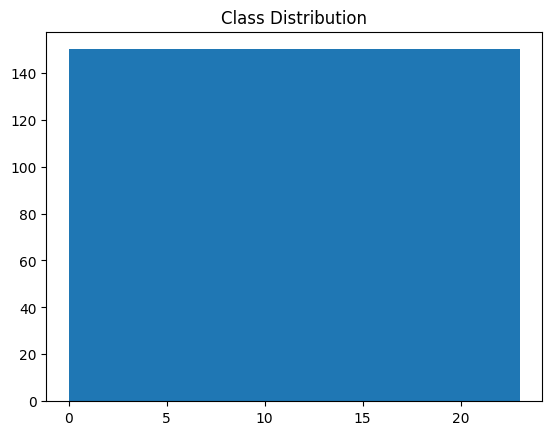

In [75]:
# Just to check class imbalances

plt.hist(y_test_class, bins=n_classes)
plt.title('Class Distribution')
plt.show()

In [76]:
# train class_model


# print(X_train.shape)
# print(X_train[0].shape)
# print(type(y_train_class))
# print(len(y_train_class))
# print(f"X_train type: {type(X_train)}")
# print(X_train)

start_time = time.time()

history = class_model.fit(
    X_train, y_train_class,
    validation_data=(X_val, y_val_class),
    epochs=20,
    batch_size=16,
    verbose=2
)

end_time = time.time()

print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

Epoch 1/20


KeyboardInterrupt: 

In [88]:
@tf.function
def reg_loss_12hr(true, pred):
    difference = tf.abs(true - pred)
    new_difference = tf.where(difference > 6.0, 12.0 - difference, difference)
    loss = tf.reduce_mean(tf.square(new_difference))

    return loss

In [89]:
# Same hyperparameters as cnn classifier
reg_model = models.Sequential([
    layers.Input(shape=(height, width, 1)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 4 (optional - add if images are large, e.g., 200x200+)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])
# CHANGE LOSS FUNCTION TO REGULAR MSE TO COMPARE AND MEASURE DIFFERENCE OF WRAPPED LOSS FUNCTION
reg_model.compile(
    optimizer=opt,
    loss=reg_loss_12hr,
    metrics=['mse'],
    run_eagerly=False
)

reg_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)              │ (None, 75, 75, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,000,147 (19.07 MB)

 Trainable params: 1,664,417 (6.35 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 3,334,770 (12.72 MB)

In [90]:
start_time = time.time()

history = reg_model.fit(
    X_train, y_train_reg,
    validation_data=(X_val, y_val_reg),
    epochs=5,
    batch_size=16,
    verbose=2
)

end_time = time.time()

print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

Epoch 1/5


NotImplementedError: numpy() is only available when eager execution is enabled.

In [80]:
# Loss function for multi head regression

def reg_loss_multi(true, pred):
    difference = tf.abs(true - pred)
    new_difference = tf.where(difference > .5, 1.0 - difference, difference)
    return tf.reduce_mean(tf.square(new_difference))

In [81]:
# Multi head regression model with same hyperparameters as other two models

multi_reg_model = models.Sequential([
    layers.Input(shape=(height, width, 1)),

    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 4 (optional - add if images are large, e.g., 200x200+)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Dense layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(2, activation='linear')
])

multi_reg_model.compile(
    optimizer=opt,
    loss=reg_loss_multi,
    metrics=['mse']
)

reg_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 75, 75, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 75, 75, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 9, 9, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,000,147 (19.07 MB)

 Trainable params: 1,664,417 (6.35 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 3,334,770 (12.72 MB)

In [ ]:
start_time = time.time()

history = multi_reg_model.fit(
    X_train, y_train_norm,
    validation_data=(X_val, y_val_norm),
    epochs=5,
    batch_size=16,
    verbose=2
)

end_time = time.time()

print(f"Training time: {(end_time - start_time)/60:.2f} minutes")

Epoch 1/5
1800/1800 - 269s - 149ms/step - loss: 0.1389 - mse: 0.4087 - val_loss: 0.0831 - val_mse: 0.3146
Epoch 2/5
1800/1800 - 278s - 155ms/step - loss: 0.0834 - mse: 0.3230 - val_loss: 0.0830 - val_mse: 0.3235
Epoch 3/5
